[View in Colaboratory](https://colab.research.google.com/github/Nourahussein/Plant-seedling-classification/blob/master/FINAL_seedling.ipynb)

# **Unziping train file**

show the dirctoris in train

In [1]:
#see contents of train file
!ls "/home/aninda/Desktop/V2_Plant_Seedling_Classification/V2_Plant_Seedling_Dataset"


 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherd’s Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [ ]:
import shutil

shutil.rmtree("/home/aninda/Desktop/V2_Plant_Seedling_Classification/V2_Plant_Seedling_Dataset/nonsegmentedv2")

In [ ]:
#change dirctory 
#import os 
#os.chdir("train")
#cwd = os.getcwd()


In [2]:
#list of useful imports that  I will use

import os

import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns


In [3]:
#save the path into variable to use it easily next times.
TRAIN_DATA_FOLDER= "/home/aninda/Desktop/V2_Plant_Seedling_Classification/V2_Plant_Seedling_Dataset"

 **Read images and remove missing values** 
 save images in **images** list

In [4]:
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAIN_DATA_FOLDER):
    class_folder_path = os.path.join(TRAIN_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

    

print("Done")
        

Done


number of all images

In [5]:
len(images)

5539

**resizing images**

In [6]:
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res
#resized=[]
#for image in images:
#  ressized= resize_images(images[image])

In [7]:
#save resized images into images.
images = [resize_images(img) for img in images]
print("Done")

Done


In [8]:
images[0].shape

(256, 256, 3)

#number of images in each class 

In [9]:
#see number of images in each lablel
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)
#for key,value in images_per_class.items():
   # print("number of {0} images is  -> {1}".format(key, len(value)))
  
for label in set(classes):

  print("number of {} images is  -> {}".format(
        label, 
        len(images[classes == label])))
        
  


images shape:  (5539, 256, 256, 3)
classes shape:  (5539,)
number of Black-grass images is  -> 309
number of Shepherd’s Purse images is  -> 274
number of Common wheat images is  -> 253
number of Fat Hen images is  -> 538
number of Cleavers images is  -> 335
number of Scentless Mayweed images is  -> 607
number of Loose Silky-bent images is  -> 762
number of Charlock images is  -> 452
number of Common Chickweed images is  -> 713
number of Small-flowered Cranesbill images is  -> 576
number of Sugar beet images is  -> 463
number of Maize images is  -> 257


# plot the distrbution of number of images

Text(0.5, 0.98, 'Categorical Plotting')

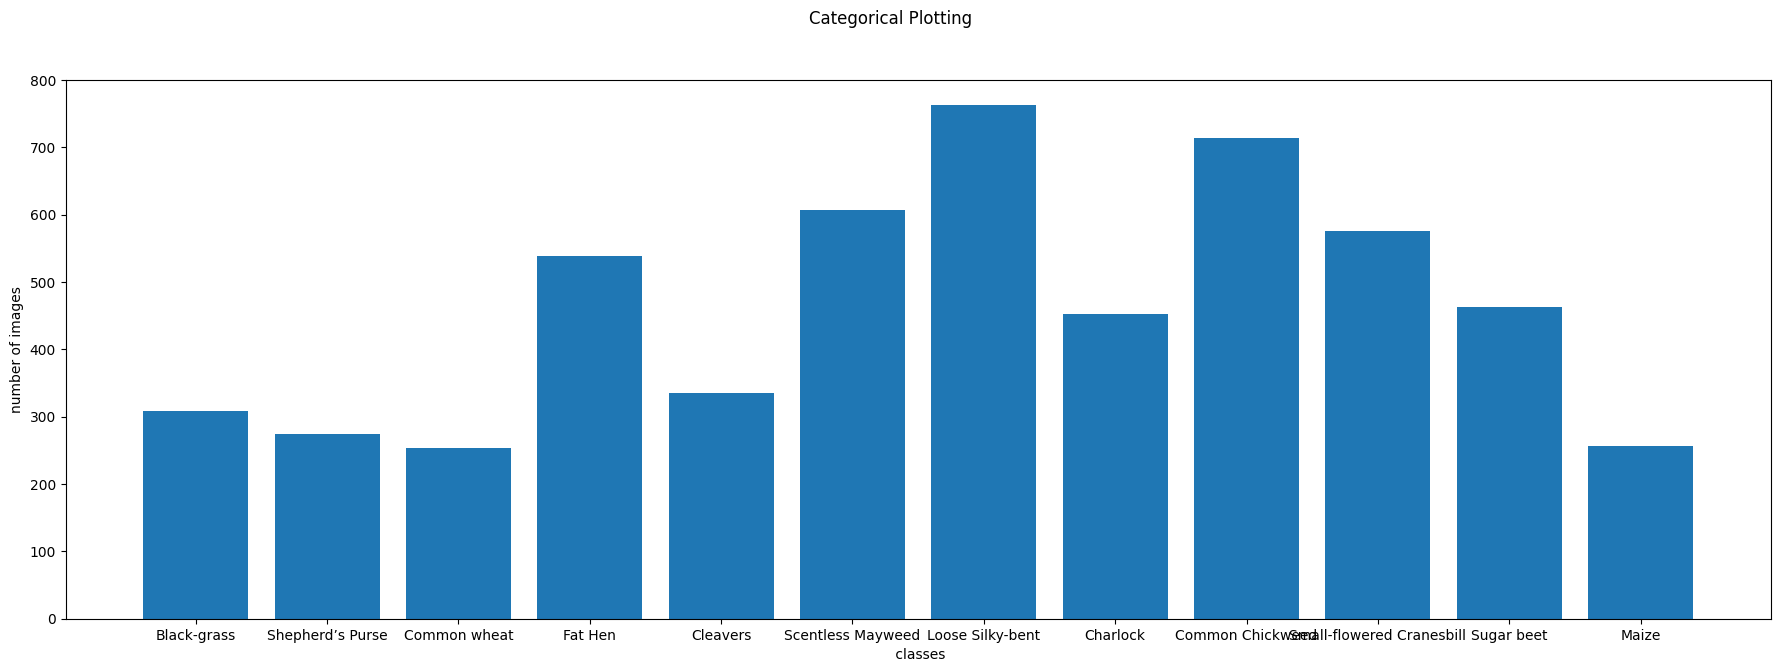

In [10]:
values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values)
ax.set_xlabel(" classes")
ax.set_ylabel("number of images")
#axs[1].scatter(label, )
  #axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

# look at image after resize

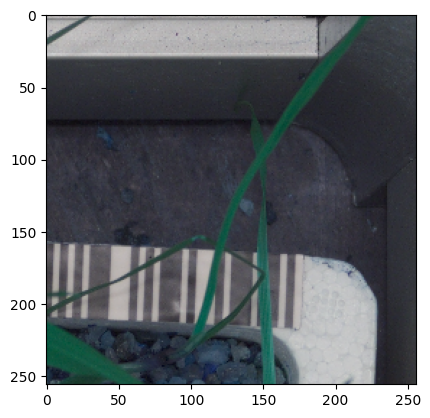

In [11]:
plt.imshow(images[50])


# data Exploration  

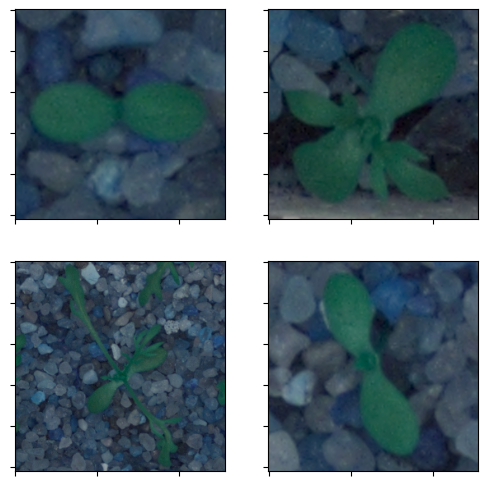

In [12]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("Scentless Mayweed")

In [13]:
#!ls "train/Scentless Mayweed" 1300c3cd9.png

img = cv2.imread("/home/aninda/Desktop/V2_Plant_Seedling_Classification/V2_Plant_Seedling_Dataset/Scentless Mayweed/21.png")


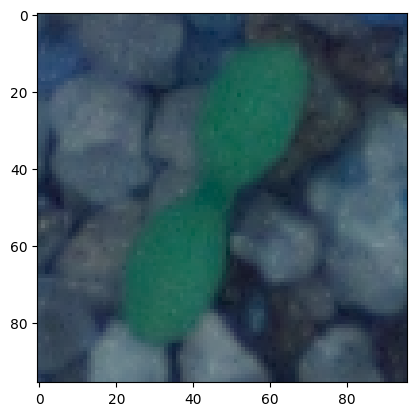

In [14]:
plt.imshow(img)

#Apply image processing on the images 
* convert image from RGB to HSV 
* Apply closing operation(one of morphological operation)
* Apply segmentation 
* Apply sharpening 

In [15]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp



# put all those functions together.

In [16]:
def segment(img):

  #image_mask = create_mask_for_plant(img)
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

# itrate on all images

In [17]:
for indx, image in enumerate(images):
  try:
     images[indx] = segment(image)
      
  except:
    print(indx)
    continue
      
    
  

# plot sample image to see diffrence before and after

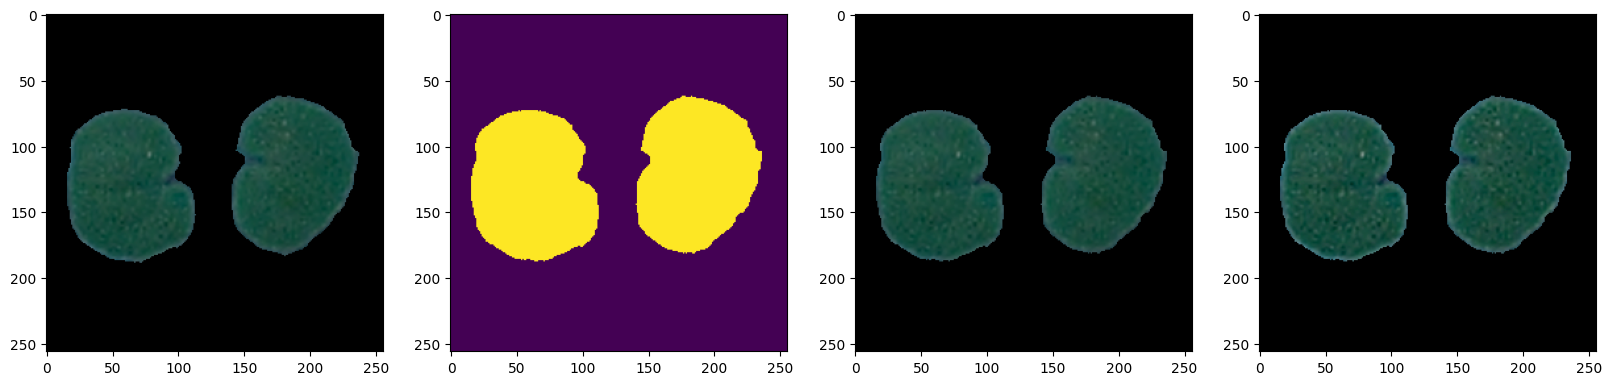

In [18]:
image = images[classes == "Small-flowered Cranesbill"][40]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

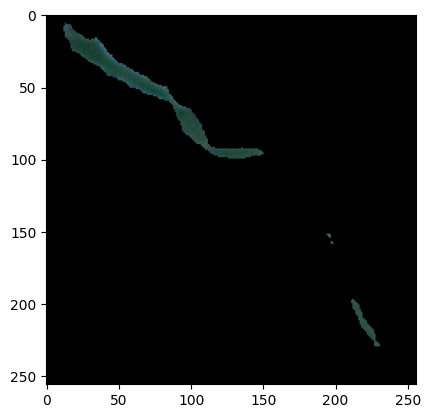

In [19]:
plt.imshow(images[0])

In [20]:
images.shape

(5539, 256, 256, 3)

# Label encoder 

In [21]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)

In [22]:
y[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Spliting data into training and testing set
* training set : 70%

*  testing set: 30% 

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [24]:
X_train.shape


(3877, 256, 256, 3)

# Create validarion set 
* split test data into 50% test, 50% validation

In [25]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [26]:
print(X_test.shape)
print(X_val.shape)

(831, 256, 256, 3)
(831, 256, 256, 3)



# Resnet-50 MODEL 


In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Load ResNet50 without the top layer and with ImageNet weights
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(256, 256, 3)))

# Freeze the base model layers
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(12, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)


# Print summary
model.summary()


2025-07-16 10:44:07.984453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-16 10:44:08.093719: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 10:44:08.096997: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aninda/anaconda3/envs/seedlings/lib/python3.10/site-packages/cv2/../../lib64:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# **Data augmentation **

In [28]:
from keras.preprocessing.image import ImageDataGenerator

# Data augmentation setup
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# Fit the generator to the training data
datagen.fit(X_train)


In [37]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)


model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [36]:
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np

batch_size=32

# Compute class weights
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights = dict(enumerate(class_weights))

# Define callbacks
checkpoint = ModelCheckpoint(
    filepath='plant_seedlings_resnet_best_model_cw_aug.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=1e-6
)

# Training the model with data generator and class weights
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=30,
    validation_data=(X_val, Y_val),
    steps_per_epoch=X_train.shape[0] // batch_size,
    class_weight=class_weights,
    callbacks=[learning_rate_reduction],
    verbose=2
)


Epoch 1/30
121/121 - 83s - loss: 1.5528 - accuracy: 0.5030 - val_loss: 0.6321 - val_accuracy: 0.7894 - lr: 0.0010 - 83s/epoch - 687ms/step
Epoch 2/30
121/121 - 79s - loss: 0.9343 - accuracy: 0.6624 - val_loss: 0.5667 - val_accuracy: 0.7846 - lr: 0.0010 - 79s/epoch - 656ms/step
Epoch 3/30
121/121 - 79s - loss: 0.7738 - accuracy: 0.7238 - val_loss: 0.4662 - val_accuracy: 0.8195 - lr: 0.0010 - 79s/epoch - 657ms/step
Epoch 4/30
121/121 - 80s - loss: 0.6919 - accuracy: 0.7438 - val_loss: 0.4724 - val_accuracy: 0.8014 - lr: 0.0010 - 80s/epoch - 660ms/step
Epoch 5/30
121/121 - 80s - loss: 0.6580 - accuracy: 0.7625 - val_loss: 0.3823 - val_accuracy: 0.8628 - lr: 0.0010 - 80s/epoch - 661ms/step
Epoch 6/30
121/121 - 80s - loss: 0.6070 - accuracy: 0.7748 - val_loss: 0.4700 - val_accuracy: 0.8087 - lr: 0.0010 - 80s/epoch - 658ms/step
Epoch 7/30
121/121 - 80s - loss: 0.5844 - accuracy: 0.7909 - val_loss: 0.4005 - val_accuracy: 0.8580 - lr: 0.0010 - 80s/epoch - 658ms/step
Epoch 8/30

Epoch 8: Reduce

In [38]:
# Unfreeze last few layers of ResNet50
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile again with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [39]:
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np

# Compute class weights
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights = dict(enumerate(class_weights))

# Define callbacks
checkpoint = ModelCheckpoint(
    filepath='plant_seedlings_resnet50_best_model_cw_aug.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=1e-10
)

# Training the model with data generator and class weights
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=50,
    validation_data=(X_val, Y_val),
    steps_per_epoch=X_train.shape[0] // batch_size,
    class_weight=class_weights,
    callbacks=[learning_rate_reduction,checkpoint],
    verbose=2
)


Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.81227, saving model to plant_seedlings_resnet50_best_model_cw_aug.h5
121/121 - 98s - loss: 1.5312 - accuracy: 0.7620 - val_loss: 0.7315 - val_accuracy: 0.8123 - lr: 1.0000e-05 - 98s/epoch - 813ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.81227 to 0.85439, saving model to plant_seedlings_resnet50_best_model_cw_aug.h5
121/121 - 93s - loss: 0.6555 - accuracy: 0.8336 - val_loss: 0.4865 - val_accuracy: 0.8544 - lr: 1.0000e-05 - 93s/epoch - 769ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.85439 to 0.85680, saving model to plant_seedlings_resnet50_best_model_cw_aug.h5
121/121 - 93s - loss: 0.5336 - accuracy: 0.8507 - val_loss: 0.4179 - val_accuracy: 0.8568 - lr: 1.0000e-05 - 93s/epoch - 772ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.85680 to 0.87485, saving model to plant_seedlings_resnet50_best_model_cw_aug.h5
121/121 - 92s - loss: 0.4247 - accuracy: 0.8499 - val_loss: 0.3775 - val_accuracy: 0.87

In [40]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = 32)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.1565103530883789
Test accuracy: 0.9290012121200562


# Model Evaluation

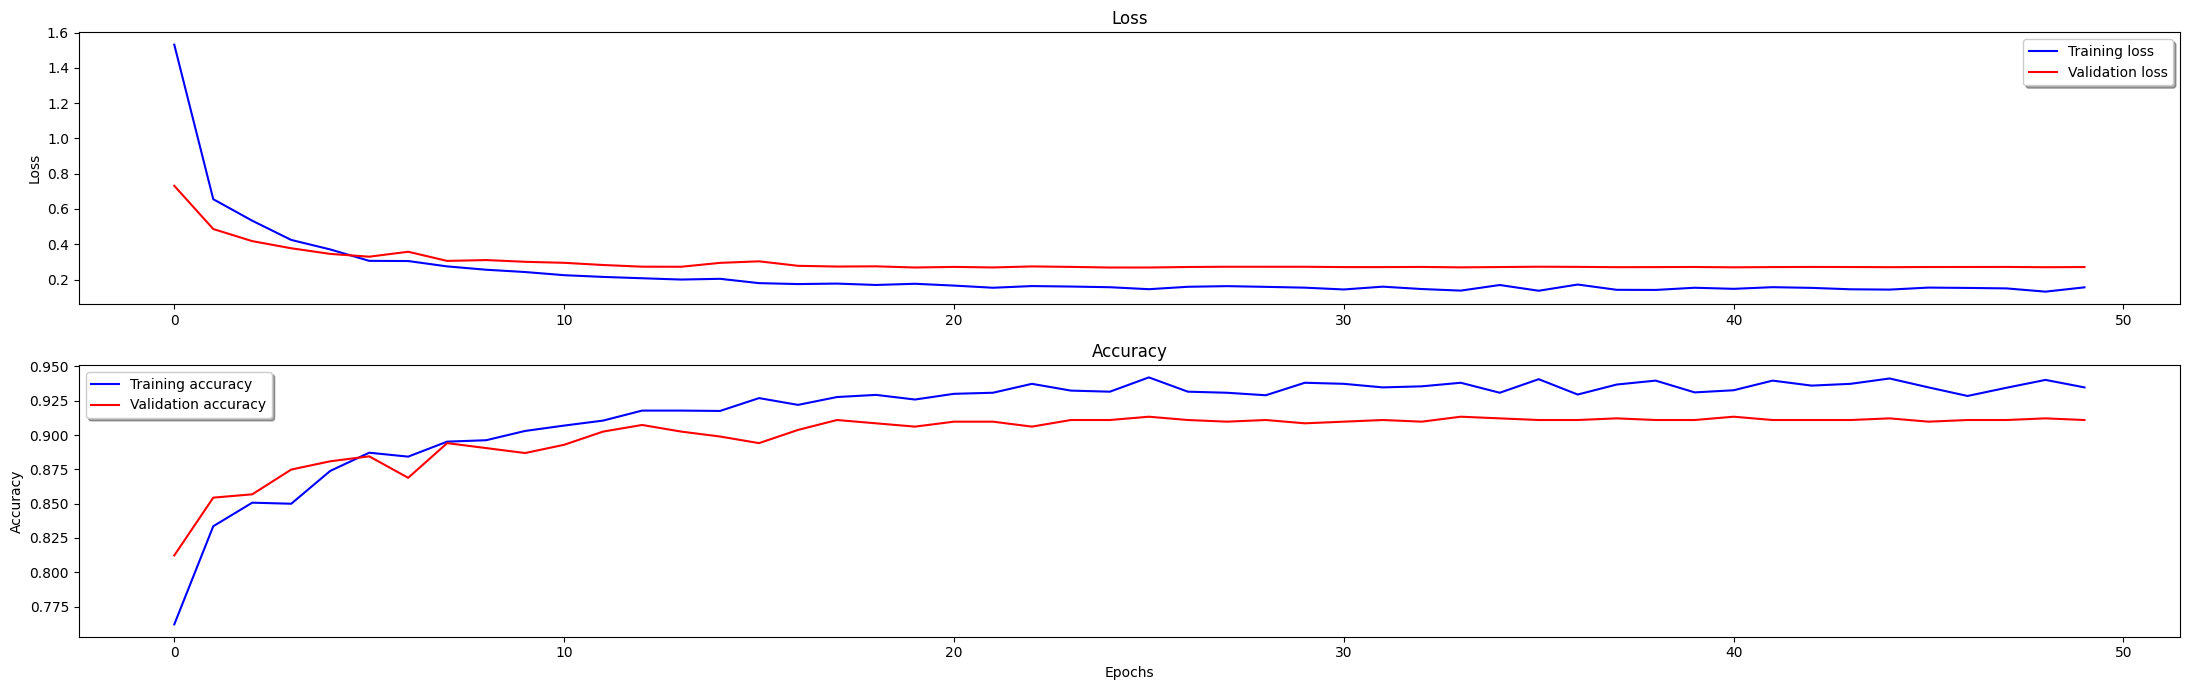

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(22, 7))

# Loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title("Loss")
ax[0].set_ylabel("Loss")

# Accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title("Accuracy")
ax[1].set_ylabel("Accuracy")

plt.xlabel("Epochs")
plt.tight_layout()


# Save the plot before showing
plt.savefig('my_plot.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution



plt.show()


In [ ]:
#prediction = model.predict(X_test)

# Confusion Matrix

26/26 [==============================] - 14s 518ms/step


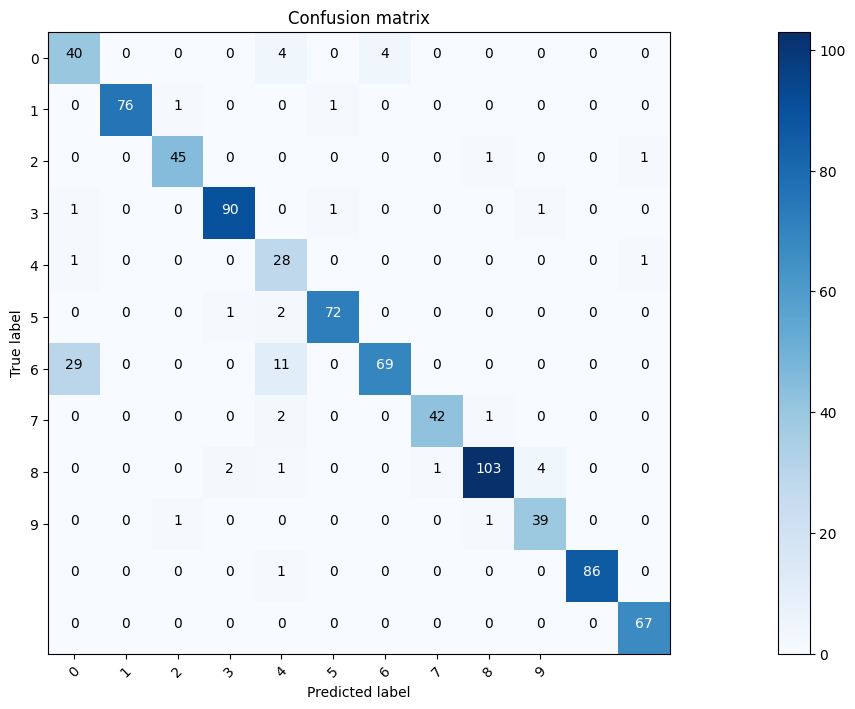

In [42]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

1/1 [==============================] - 0s 85ms/step
Predicted class: Maize
Actual class: Common wheat


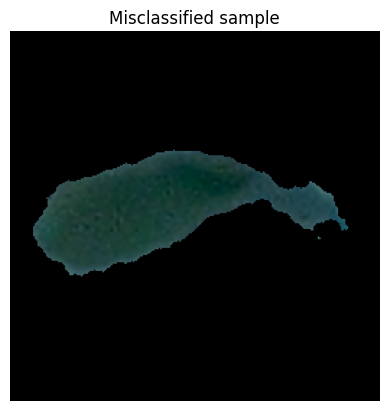

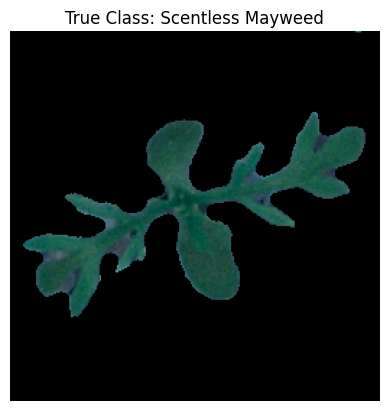

In [43]:
# Predict class indices from the test set
Predicted_classes = np.argmax(model.predict(X_test), axis=1)

# Convert one-hot test labels to class indices
y_test_labels = np.argmax(y_test, axis=1)

# Identify wrong predictions
wrong_preds_indices = np.where(Predicted_classes != y_test_labels)[0]
wrong_preds = X_test[wrong_preds_indices]

# Pick one misclassified sample to visualize
i = 10  # You can choose any index < len(wrong_preds)
sample = wrong_preds[i]

# Predict on the chosen sample
pred = np.argmax(model.predict(sample.reshape(1, 256, 256, 3)), axis=1)[0]
act = y_test_labels[wrong_preds_indices[i]]

print("Predicted class:", enc.classes_[pred])
print("Actual class:", enc.classes_[act])

plt.imshow(sample)
plt.title("Misclassified sample")
plt.axis('off')
plt.show()

# Show a correctly classified example
plt.imshow(X_test[10])
true_label = enc.inverse_transform(y_test[10].reshape(1, -1))[0]
plt.title(f"True Class: {true_label}")
plt.axis('off')
plt.show()


In [44]:
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# ---- Predict probabilities and classes ----
y_probs = model.predict(X_test)                      # shape: (n_samples, 12)
y_pred = np.argmax(y_probs, axis=1)                  # predicted class indices
y_true = np.argmax(y_test, axis=1)                   # actual class indices

# ---- Classification Report ----
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=enc.classes_))


26/26 [==============================] - 14s 524ms/step
Classification Report:

                           precision    recall  f1-score   support

              Black-grass       0.42      0.76      0.54        33
                 Charlock       1.00      1.00      1.00        62
                 Cleavers       1.00      0.97      0.98        58
         Common Chickweed       1.00      0.98      0.99       115
             Common wheat       0.84      0.91      0.87        45
                  Fat Hen       0.99      0.98      0.98        84
         Loose Silky-bent       0.92      0.62      0.74        97
                    Maize       0.98      1.00      0.99        42
        Scentless Mayweed       0.97      0.99      0.98        86
         Shepherd’s Purse       0.98      0.96      0.97        50
Small-flowered Cranesbill       1.00      0.99      0.99        88
               Sugar beet       0.93      1.00      0.97        71

                 accuracy                      

26/26 [==============================] - 14s 525ms/step


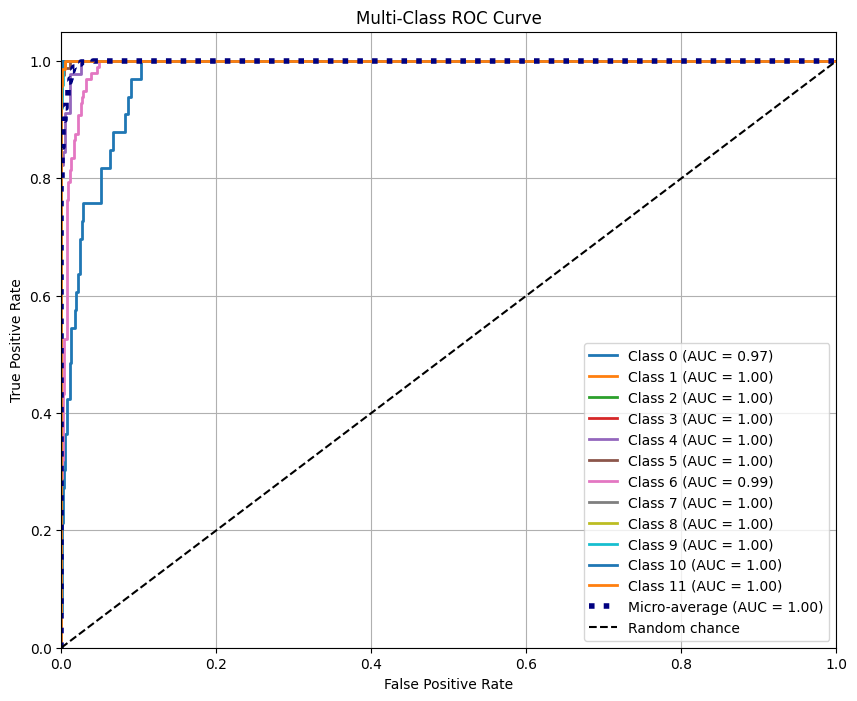

In [45]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Binarize the labels (one-hot encoded if not already)
y_test_bin = label_binarize(np.argmax(y_test, axis=1), classes=np.arange(12))
y_pred_prob = model.predict(X_test)  # Predict probabilities

# Step 2: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 3: Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Step 4: Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average (AUC = {:.2f})'.format(roc_auc["micro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
